# 11 空間構造のある階層ベイズモデル

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [50]:
using CSV
using DataFrames
using Distributed
using Distributions
using ForneyLab
using LinearAlgebra
@everywhere using Mamba
using Plots
using SparseArrays
using Statistics
using StatsBase

## 11.1 例題 : 一次元空間上の個体数分布
### 例題の一次元空間上の架空データ

In [3]:
df = CSV.read("data/section11.csv")
disallowmissing!(df)

,y,m
,Int64,Float64
1,0,2.15498
2,3,3.25417
3,2,4.62867
4,5,6.23412
5,6,7.99073
6,16,9.79447
7,8,11.5334
8,14,13.1043
9,11,14.4263


横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

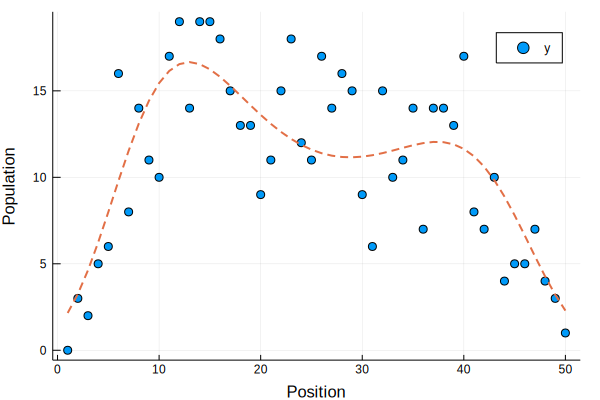

In [4]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")

## 11.2 階層ベイズモデルに空間構造を組み込む
まず, 個体数$y_i$は, すべでの区画で共通する平均$\lambda$のポアソン分布に従うとしてみる.
\begin{align}
y_i & \sim \text{Poisson}(\lambda),\\
p(y_j \mid \lambda) & = \frac{\lambda^{y_i}\exp(-\lambda)}{y_j!}
\end{align}

このように仮定してすると, 平均$\lambda$と標本平均と等しいとしてみる.
### 標本平均

In [5]:
mean(df.y)

10.88

### 標本分散
ところが標本分散を求めてみると,

In [6]:
var(df.y)

27.373061224489796

となり, 標本平均の3倍近くなっている. そのため個体数が全ての区画で共通する平均$\lambda$のPoisson分布に従うと言う仮定は成立していなさそう.


そのため, 区間$j$ごとに平均$\lambda_i$が異なっているとし, 平均個体数を切片$\beta$と場所差$r_j$を用いて
\begin{align}
\log \lambda_i = \beta + r_j
\end{align}
と表す.
### 11.2.1. 空間構造のない階層事前分布
場所差$r_j$の事前分布を第10章で使ったような階層事前分布
\begin{align}
r_j & \sim \text{Normal}(0, s^2),\\
p(r_j \mid s) & = \frac{1}{\sqrt{2\pi s^2}}\exp \left( -\frac{r_j^2}{2s^2} \right)
\end{align}
であるとしてモデリングしてみる.

In [7]:
model1 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) ->
            UnivariateDistribution[
            Normal(0, s) for _ in 1:N
        ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [8]:
data1 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]

In [9]:
inits1 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.137089, -0.152411, 0.0153259, 0.115321, 0.0624283, 0.0385864, 0.0653903, 0.139665, -0.153868, 0.00291767  …  -0.199281, 0.129809, -0.107055, -0.137533, -0.213235, -0.0218111, 0.106826, 0.0215408, 0.0149408, -0.000807076])    
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0469286, 0.00485608, 0.0636115, -0.0294723, 0.143737, -0.138896, -0.0725889, 0.0218922, 0.0378039, -0.14889  …  -0.0279078, 0.0321283, 0.212532, 0.0122018, -0.00310484, -0.146736, -0.0447578, 0.0815838, 0.00817713, -0.11647])
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0601599, 0.104371, 0.0795409, 0.134523, 0.00885698, -0.0422567, 0.130428, -0.0705829, -0.105115, -0.062665  …  0.0771621, -0.0811492, -0.0559822, -0.0340893, 0.0166285, 0.0564504, -0.251469, -0.09

In [10]:
scheme1 = [
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                         
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                 

In [11]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data1, inits1, 21000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [3:07:30 of 3:07:35 remaining]
      From worker 3:	Chain 2:   0% [3:10:28 of 3:10:33 remaining]
      From worker 4:	Chain 3:   0% [3:13:41 of 3:13:46 remaining]
      From worker 3:	Chain 2:  10% [0:01:40 of 0:01:51 remaining]
      From worker 2:	Chain 1:  10% [0:01:40 of 0:01:51 remaining]
      From worker 4:	Chain 3:  10% [0:01:40 of 0:01:52 remaining]
      From worker 3:	Chain 2:  20% [0:01:05 of 0:01:21 remaining]
      From worker 4:	Chain 3:  20% [0:01:05 of 0:01:21 remaining]
      From worker 2:	Chain 1:  20% [0:01:05 of 0:01:22 remaining]
      From worker 3:	Chain 2:  30% [0:00:50 of 0:01:11 remaining]
      From worker 4:	Chain 3:  30% [0:00:50 of 0:01:11 remaining]
      From worker 2:	Chain 1:  30% [0:00:50 of 0:01:12 remaining]
      From worker 3:	Chain 2:  40% [0:00:40 of 0:01:06 remaining]
      From worker 4:	Chain 3:  40% [0:00:40 of 0:01:06 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[0.302504 2.37036 … 10.1316 9.58988; 0.323262 2.3359 … 6.0072 8.65088; … ; 0.515772 2.30326 … 7.13933 3.84683; 0.505994 2.22577 … 4.83056 3.93078]

[0.468812 2.43357 … 9.39707 5.42551; 0.434759 2.30215 … 9.08374 4.24086; … ; 0.563573 2.26862 … 4.26916 5.38722; 0.463138 2.11831 … 7.50181 3.81982]

[0.388996 2.32542 … 5.44462 5.12954; 0.313084 2.23005 … 7.37068 6.84597; … ; 0.407787 2.37758 … 7.3703 4.9472; 0.466294 2.28595 … 7.01902 4.76848]

In [12]:
describe(sim1)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean        SD       Naive SE       MCSE      ESS
         s  0.4508018 0.08316681 0.0010736789 0.0014972678 2000
      beta  2.2988140 0.08196863 0.0010582104 0.0015087178 2000
 lambda[1]  4.4281235 1.61956069 0.0209084385 0.0278845039 2000
 lambda[2]  5.8971111 1.86996327 0.0241411220 0.0274522632 2000
 lambda[3]  5.4182180 1.82274067 0.0235314809 0.0269681832 2000
 lambda[4]  7.0889877 2.08814951 0.0269578943 0.0305009717 2000
 lambda[5]  7.6436740 2.19775566 0.0283729035 0.0340434812 2000
 lambda[6] 14.3383430 3.33236196 0.0430206079 0.0513099795 2000
 lambda[7]  8.7702693 2.41482834 0.0311752998 0.0313420570 2000
 lambda[8] 12.8536888 3.00870998 0.0388422788 0.0390014164 2000
 lambda[9] 10.8199019 2.69904508 0.0348445221 0.0340692952 2000
lambda[10] 10.0637788 2.54309192 0.0328311755 0.0301071637 2000
lambda[11] 15.0205065 3.38939997 0.0437569654 0.0

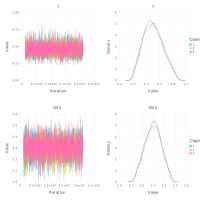

In [13]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:2], nrow = 2, ncol = 2)

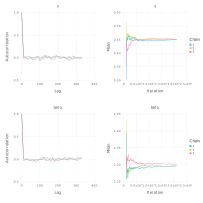

In [14]:
p2 = Mamba.plot(sim1, [:autocor, :mean], legend=true)
Mamba.draw(p2[:, 1:2], nrow = 2, ncol = 2)

$\lambda$の中央値、95%信頼区間をプロットしてみる

In [38]:
mre = quantile(sim1).value[3:end, :]

50×5 Array{Float64,2}:
  1.80285   3.2636    4.25315   5.388     8.09479
  2.85507   4.5425    5.69663   7.05495  10.0266 
  2.46086   4.1001    5.22814   6.5086    9.44372
  3.57331   5.58862   6.90356   8.37583  11.7272 
  4.03007   6.0566    7.41171   8.98197  12.6755 
  8.70138  12.0173   14.0067   16.3921   21.8017 
  4.88776   7.05017   8.50059  10.1969   14.1985 
  7.75851  10.7094   12.6189   14.6344   19.7216 
  6.21768   8.86166  10.5787   12.4629   16.7341 
  5.73033   8.23498   9.84683  11.6648   15.4709 
  9.23635  12.6407   14.7242   17.1498   22.4287 
 10.4383   13.9645   16.1867   18.7496   24.3319 
  7.74812  10.6554   12.4897   14.647    19.4966 
  ⋮                                              
  7.30985  10.0402   11.8363   13.8478   18.4127 
  9.26831  12.598    14.7382   17.16     22.2721 
  4.79825   7.14911   8.59713  10.3574   14.3212 
  4.45922   6.64324   7.986     9.55924  13.1093 
  5.72028   8.31562   9.88255  11.7575   15.9485 
  3.16839   5.06045   6.214

In [42]:
mre[:, 3]

50-element Array{Float64,1}:
  4.253149891930991 
  5.696631016630859 
  5.2281397710640265
  6.903555054644973 
  7.411710814042428 
 14.006660904968678 
  8.500592870960734 
 12.618939215060491 
 10.578703562655045 
  9.846834956923672 
 14.724222956601661 
 16.186650188763757 
 12.489734647619809 
  ⋮                 
 11.836329347175853 
 14.738197595301509 
  8.597129977571338 
  7.9860002570513675
  9.882551201447995 
  6.2142616700305116
  6.854368469154008 
  6.796848878193739 
  7.986643164522446 
  6.2418962658248   
  5.754490007460669 
  4.692646885262532 

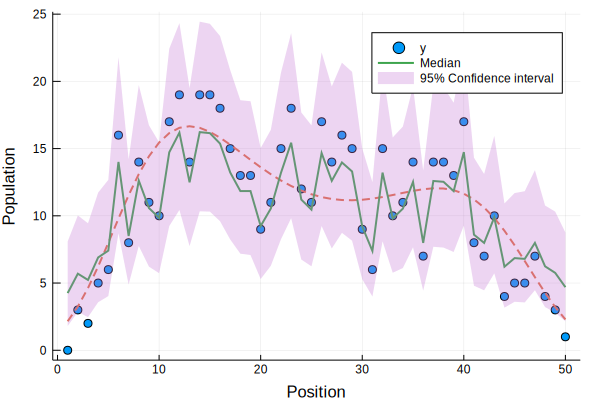

In [47]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")
plot!(1:50, mre[:, 3], linewidth = 2, label = "Median")
plot!(1:50, mre[:, 1], lw = 0, 
    fillrange = mre[:, 5],
    fillalpha = 0.3, 
    label = "95% Confidence interval")

### 11.2.2 空間構造のある階層事前分布
ある区間はそれと隣接する区間とだけ相互作用すると仮定する. 
近傍数は$n_j = 2 \ (j \neq 1, 50), 1 \ (j = 1, 50)$となる.

\begin{align}
\mu_j & = \frac{r_{j-1} + r_{j+1}}{2}\ (j \neq 1, 50), \mu_1 = r_2, \mu_{50} = r_{49},\\
r_j \mid \mu_j, s & \sim \text{Normal}\left(\mu_j, \frac{s}{\sqrt{n_j}}\right)
\end{align}
と言うモデルを考える.
## 11.3 空間統計モデルをデータに当てはめる

In [90]:
model2 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, alpha, N, D, adj) ->
            MvNormalCanon(zeros(N), 1 / (s * s) * (D - alpha * adj)),
        false
    ),
    
    alpha = Stochastic(() -> Uniform()),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [91]:
adj = spzeros(50, 50)
for i in 1:50-1
    adj[i, i+1] = 1
    adj[i+1, i] = 1
end
adj

50×50 SparseMatrixCSC{Float64,Int64} with 98 stored entries:
  [2 ,  1]  =  1.0
  [1 ,  2]  =  1.0
  [3 ,  2]  =  1.0
  [2 ,  3]  =  1.0
  [4 ,  3]  =  1.0
  [3 ,  4]  =  1.0
  [5 ,  4]  =  1.0
  [4 ,  5]  =  1.0
  [6 ,  5]  =  1.0
  [5 ,  6]  =  1.0
  [7 ,  6]  =  1.0
  [6 ,  7]  =  1.0
  ⋮
  [45, 44]  =  1.0
  [44, 45]  =  1.0
  [46, 45]  =  1.0
  [45, 46]  =  1.0
  [47, 46]  =  1.0
  [46, 47]  =  1.0
  [48, 47]  =  1.0
  [47, 48]  =  1.0
  [49, 48]  =  1.0
  [48, 49]  =  1.0
  [50, 49]  =  1.0
  [49, 50]  =  1.0

In [92]:
D = Diagonal(vec(sum(adj, dims=2)))

50×50 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    

In [93]:
data2 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => …
  :y   => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [94]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :alpha => 0.5,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.5,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.137942, -0.0768356, 0.167731, 0.114775, 0.0341382, 0.00909408, -0.0127871, 0.115052, 0.138048, -0.0536963  …  0.0510092, 0.118695, -0.0356105, -0.0156228, -0.00358952, 0.0197621, -0.0628173, -0.0872953, 0.0507188, -0.0254241])
 Dict(:alpha=>0.5,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0980723, -0.0906742, 0.0230614, -0.0806145, 0.109905, -0.0797834, 0.0947871, -0.0361248, -0.22022, 0.0992963  …  0.101155, 0.0711556, -0.16695, 0.0354789, -0.025511, -0.122998, -0.0415222, 0.0388394, 0.0437025, -0.0107524])    
 Dict(:alpha=>0.5,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.234354, -0.0860424, -0.0500091, -0.00924257, 0.2557, 0.0722035, -0.0333738, -0.23922, -0.0373016, 0.121851  …  -0.0323733, -0.0909621, 0.0395533, 0.0482839

In [104]:
scheme2 = [
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
    NUTS(:r),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                               
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:alpha, :beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                   

In [105]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 21000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [1:05:03 of 1:05:05 remaining]
      From worker 4:	Chain 1:   0% [1:05:07 of 1:05:08 remaining]
      From worker 2:	Chain 2:   0% [1:05:02 of 1:05:04 remaining]
      From worker 4:	Chain 1:  10% [0:07:03 of 0:07:50 remaining]
      From worker 3:	Chain 3:  10% [0:07:31 of 0:08:21 remaining]
      From worker 2:	Chain 2:  10% [0:07:37 of 0:08:27 remaining]
      From worker 4:	Chain 1:  20% [0:05:53 of 0:07:22 remaining]
      From worker 3:	Chain 3:  20% [0:06:09 of 0:07:42 remaining]
      From worker 2:	Chain 2:  20% [0:06:15 of 0:07:48 remaining]
      From worker 4:	Chain 1:  30% [0:04:49 of 0:06:53 remaining]
      From worker 3:	Chain 3:  30% [0:05:05 of 0:07:16 remaining]
      From worker 2:	Chain 2:  30% [0:05:09 of 0:07:21 remaining]
      From worker 4:	Chain 1:  40% [0:04:03 of 0:06:45 remaining]
      From worker 3:	Chain 3:  40% [0:04:12 of 0:06:59 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[0.253694 0.994648 … 3.34034 2.3249; 0.173977 0.986404 … 5.53834 3.75045; … ; 0.374052 0.975922 … 3.21073 1.48989; 0.392428 0.962192 … 3.35999 2.68236]

[0.341856 0.974437 … 4.36461 3.27225; 0.434391 0.980916 … 2.21313 1.46374; … ; 0.32913 0.945174 … 3.63843 2.29994; 0.286594 0.957931 … 3.9826 5.34047]

[0.297831 0.999248 … 3.578 4.20569; 0.293429 0.999815 … 2.31594 1.71074; … ; 0.394904 0.992716 … 2.59811 3.52355; 0.184893 0.996136 … 4.35118 4.19008]

In [106]:
describe(sim2)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
               Mean         SD        Naive SE       MCSE         ESS   
         s  0.28761654 0.071795807 0.00092687988 0.0021383710 1127.28068
     alpha  0.97661904 0.029062558 0.00037519601 0.0011483287  640.52375
      beta  2.11558778 0.598616189 0.00772810177 0.0714620245   70.16916
 lambda[1]  2.80077047 1.069271758 0.01380423904 0.0238247083 2000.00000
 lambda[2]  3.38605739 1.060106598 0.01368591733 0.0229013356 2000.00000
 lambda[3]  4.00102048 1.129446332 0.01458108945 0.0237155205 2000.00000
 lambda[4]  5.36816165 1.321514554 0.01706067953 0.0267428568 2000.00000
 lambda[5]  7.19687664 1.591026071 0.02054005825 0.0242582889 2000.00000
 lambda[6] 10.70498594 2.327689520 0.03005034248 0.0404072933 2000.00000
 lambda[7] 10.21783260 2.054034262 0.02651746830 0.0254406905 2000.00000
 lambda[8] 11.87847146 2.324363861 0.03000740841 0.0299428682 2000.00000
 lamb

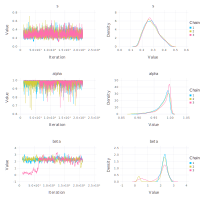

In [107]:
p3 = Mamba.plot(sim2, legend = true)
Mamba.draw(p3[:, 1:3], nrow = 3, ncol = 2)

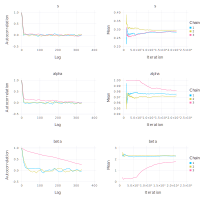

In [108]:
p4 = Mamba.plot(sim2, [:autocor, :mean], legend=true)
Mamba.draw(p4[:, 1:3], nrow = 3, ncol = 2)